# Lane Navigation using Nvidia Model
Author: Warren Harper

Date: 2021-11-07

This model is the training portion of my final year Computer Science project for WGU. I will be using captured driving data in order to teach Arnie (the car) how to navigate a lane.

In [ ]:
# Mount my Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/drive/MyDrive/Colab Notebooks/arnie_lane_navigation'

Mounted at /content/gdrive


In [ ]:
model_output_dir = '/content/gdrive/MyDrive/Colab Notebooks/arnie_lane_navigation'

## Import Required Packages

In [ ]:
# Install compatible version of Tensorflow
!pip uninstall tensorflow -y
!pip install  tensorflow==2.0

Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 86.3 MB 38 kB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 449 kB 35.6 MB/s 
     |████████████████████████████████| 3.8 MB 23.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=2197d6a93d8d36def06458e03bbd7405fc4701f2936cb3b3418d70ae3cf1c1a5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-

In [ ]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'tensorflow.keras.__version__: {tensorflow.keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.0.0
tensorflow.keras.__version__: 2.2.4-tf


## Load Train Data

image_path: /content/gdrive/MyDrive/Colab Notebooks/training_data_2/car_video210720_151209_027_072.png
steering_Angle: 72


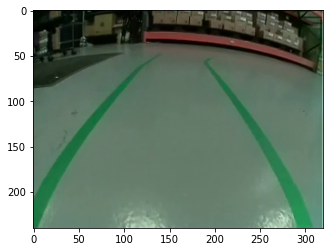

In [ ]:
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/training_data_2'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


(array([2.0000, 1.0000, 5.0000, 10.0000, 8.0000, 37.0000, 14.0000, 46.0000,
        40.0000, 50.0000, 37.0000, 65.0000, 43.0000, 76.0000, 59.0000,
        55.0000, 132.0000, 61.0000, 81.0000, 65.0000, 36.0000, 20.0000,
        16.0000, 2.0000, 4.0000]),
 array([52.0000, 54.3600, 56.7200, 59.0800, 61.4400, 63.8000, 66.1600,
        68.5200, 70.8800, 73.2400, 75.6000, 77.9600, 80.3200, 82.6800,
        85.0400, 87.4000, 89.7600, 92.1200, 94.4800, 96.8400, 99.2000,
        101.5600, 103.9200, 106.2800, 108.6400, 111.0000]),
 <a list of 25 Patch objects>)

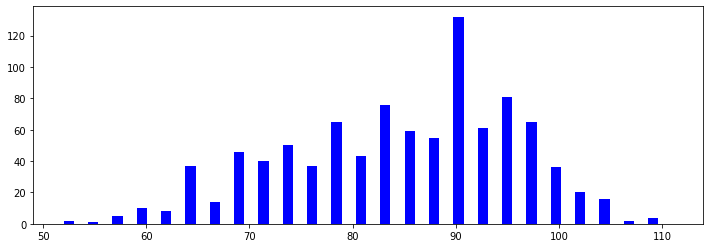

In [ ]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

The graph above represents the steering angle, 90 degrees being straight. Most of the data is orientated towards 90 since the car is mostly driving straight in the training data

Training data: 772
Validation data: 193


Text(0.5, 1.0, 'Validation Data')

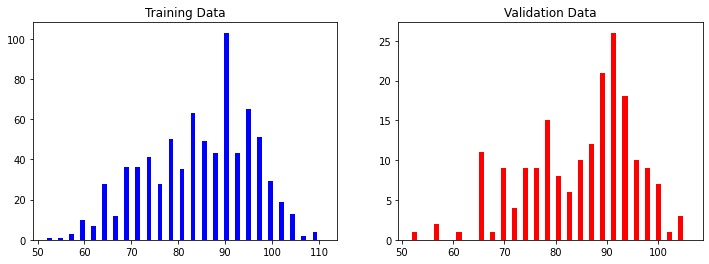

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')


##Image Augumentation
We only have a limited training data set. Nvidia, Tesla and other big aelf driving car companies have thousands of hours of traning data. In order to expand our data we'll augment the images in different ways.

1. Zoom
1. Pan
1. Adjust brightness
1. Flip the image horizontally (also flip the steering angle)
1. Gaussian blur




Text(0.5, 1.0, 'zoomed')

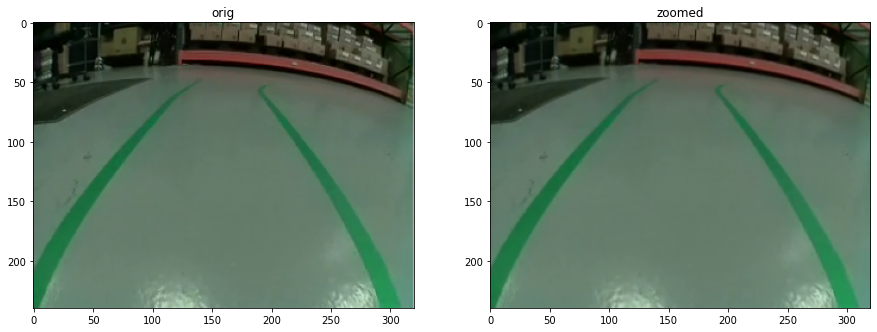

In [ ]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

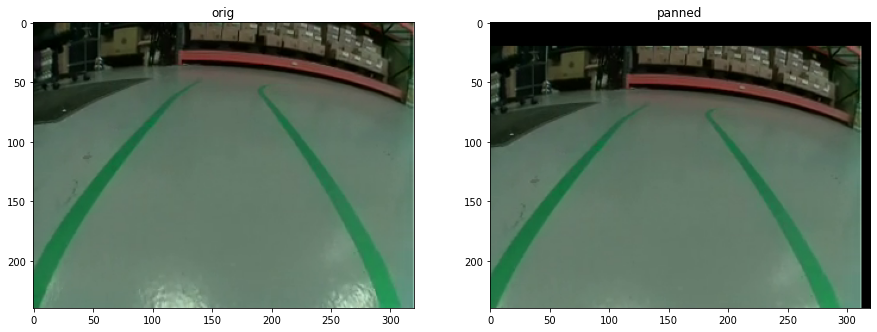

In [ ]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

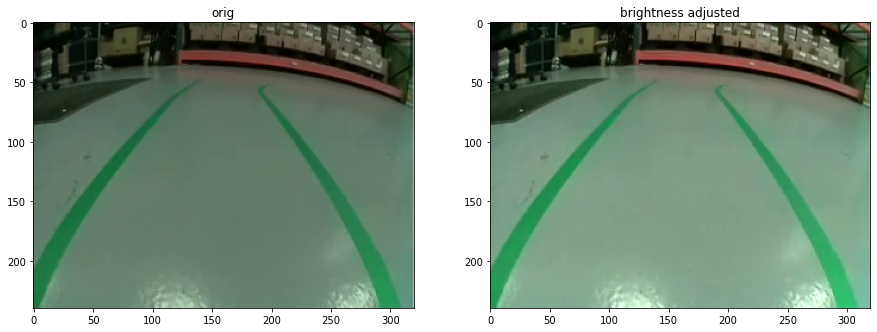

In [ ]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

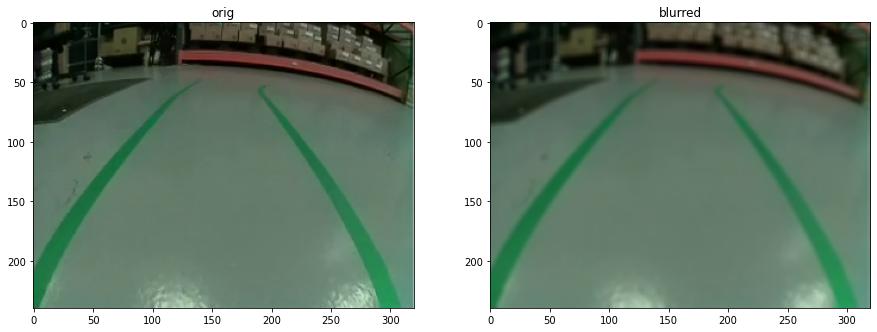

In [ ]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=72')

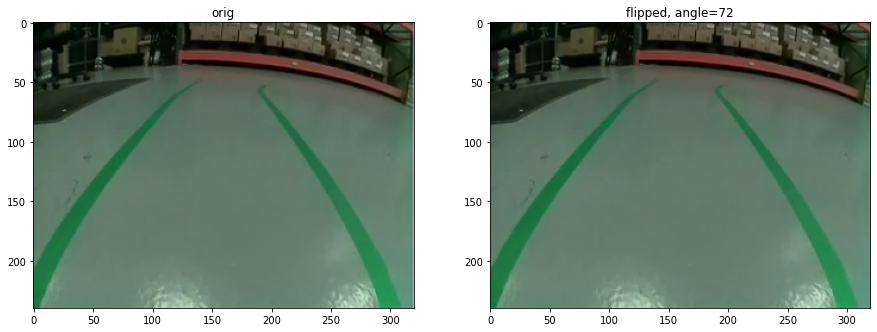

In [ ]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

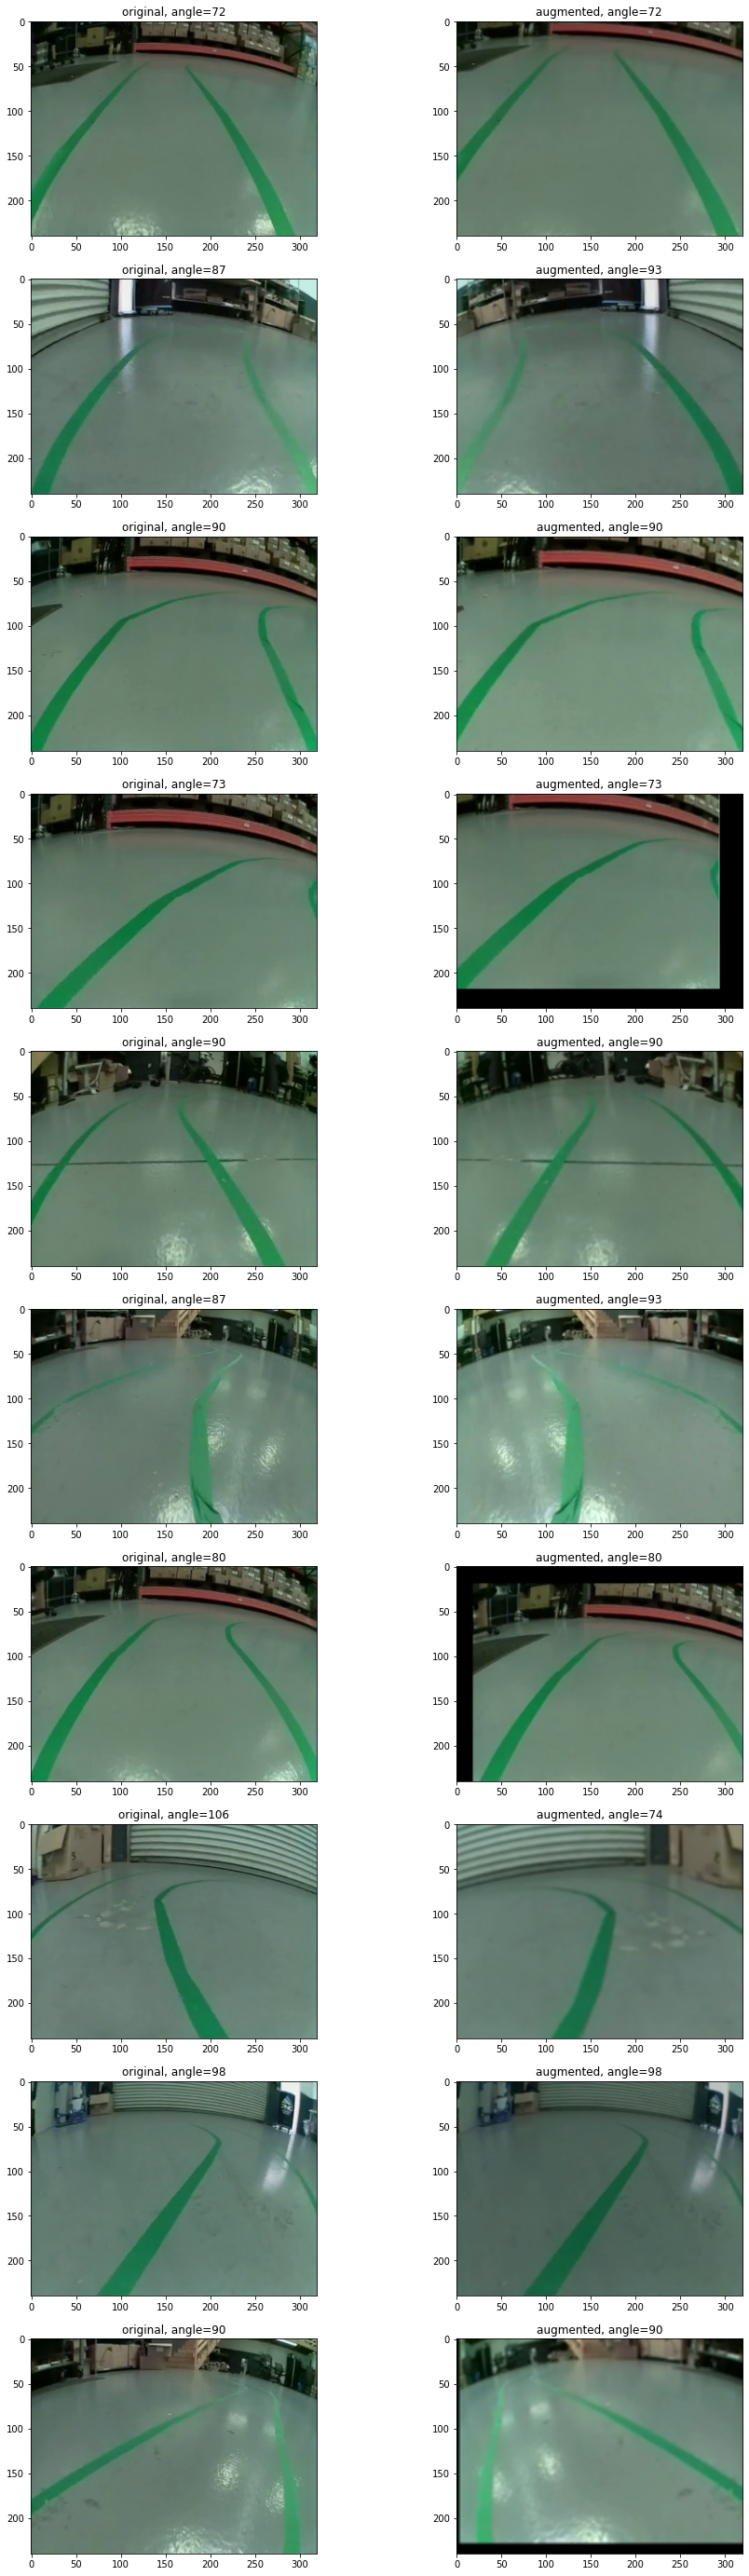

In [ ]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

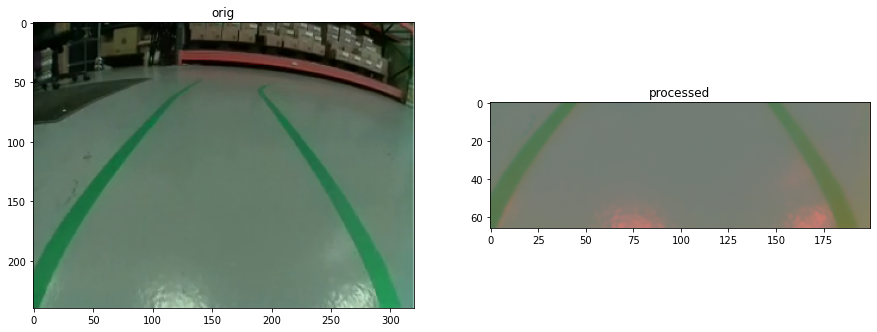

In [ ]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

This is how the Nvidia model is contructed. Near the bottom is the input layer with a resolution of 66 x 200 ![](https://raw.githubusercontent.com/wnharper/arnie/09d825c46ac83aad37d3c311f52ac7d1cc5f29dd/data/nvidia_model.jpeg
) .



In [ ]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [ ]:
model = nvidia_model()
print(model.summary())
# check that there are 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

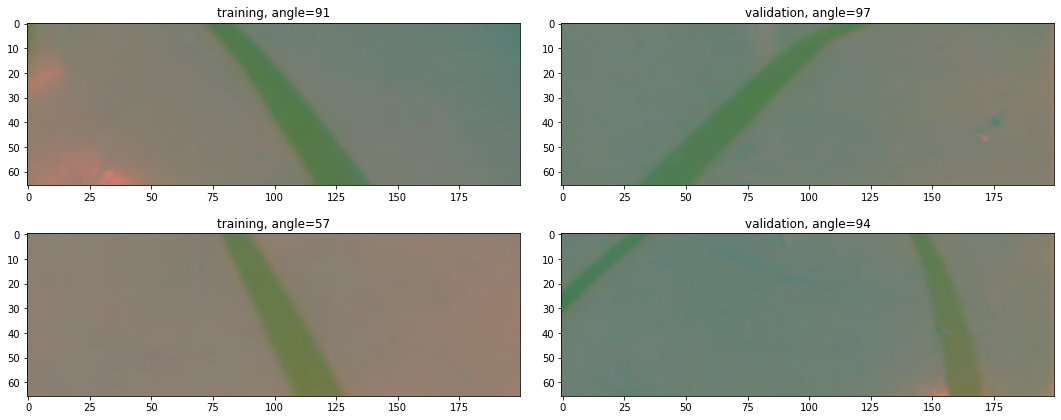

In [ ]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [ ]:
# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [ ]:
# This is a dummy command to prevent the training from starting if we Run All. It will throw an error and halt the program.
DO_NOT_RUN_ALL_CELLS

In [ ]:
# load a previously saved model. If starting from scratch, comment this out until first model is built
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/arnie_lane_navigation/lane_navigation_tf.tf')

In [ ]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# Save model output to TF format so that it can be loaded for continued training
model.save(os.path.join(model_output_dir,'lane_navigation_tf.tf'))

# Save in h5 format to use with car
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)



Epoch 1/10
299/300 [============================>.] - ETA: 2s - loss: 354.5451
Epoch 00001: val_loss improved from inf to 128.29960, saving model to /content/gdrive/MyDrive/Colab Notebooks/arnie_lane_navigation/lane_navigation_check.h5
300/300 [==============================] - 887s 3s/step - loss: 353.7535 - val_loss: 128.2996
Epoch 2/10
299/300 [============================>.] - ETA: 1s - loss: 154.7630
Epoch 00002: val_loss improved from 128.29960 to 115.94439, saving model to /content/gdrive/MyDrive/Colab Notebooks/arnie_lane_navigation/lane_navigation_check.h5
300/300 [==============================] - 685s 2s/step - loss: 154.7970 - val_loss: 115.9444
Epoch 3/10
299/300 [============================>.] - ETA: 1s - loss: 155.4532
Epoch 00003: val_loss did not improve from 115.94439
300/300 [==============================] - 698s 2s/step - loss: 155.4134 - val_loss: 128.0309
Epoch 4/10
299/300 [============================>.] - ETA: 1s - loss: 152.7206
Epoch 00004: val_loss improve

## Check and compare trained model to validation data


In [ ]:
history.history


{'loss': [137.7858299001058,
  126.41491859436036,
  116.30886611938476,
  109.52796633402507,
  103.85454261779785,
  101.2812124633789,
  94.2921517944336,
  92.28596591949463,
  86.89132174173992,
  82.31539831797282],
 'val_loss': [121.67144660949707,
  110.97251647949219,
  114.54726776123047,
  107.8130460357666,
  88.24870693206788,
  87.99994352340698,
  78.05258068084717,
  70.51742921829224,
  73.24734687805176,
  66.75615135192871]}

In [ ]:
# plot training and validation losses
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

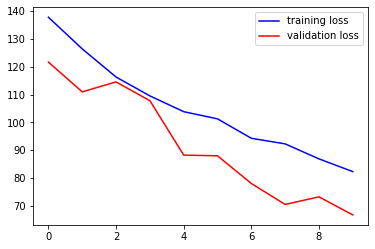

In [ ]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

If the training is successful then the graphs should converge down to the right.

In [ ]:
## Check MSE and R Squared values

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model('/content/gdrive/MyDrive/Colab Notebooks/arnie_lane_navigation/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

In [ ]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

## References

1. Rayan Slim, Amer Sharaf, Jad Slim (2017) *The Complete Self-Driving Car Course*. Udemy

1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia 
